# Model Creation and Selection

This notebook trains and creates multiple models by using a **labeled dataset** that was created from the **build_labeled_trends.ipynb** file. The specific data set used is the **labeled_trends.csv** file; this data was utilized to train the model.

## 📋 Workflow Overview

This notebook follows these key steps:

1. **Data Upload & Setup** - Upload the labeled trends dataset and install required packages
2. **Configuration** - Define model hyperparameters and preprocessing settings
3. **Data Loading & Exploration** - Load data and examine class distribution
4. **Feature Engineering** - Select features and handle missing values
5. **Train/Test Split** - Create time-based split to prevent data leakage
6. **Preprocessing** - Impute missing values, scale features, handle class imbalance
7. **Model Training** - Train 5 different models (XGBoost, LightGBM, Random Forest, Gradient Boosting, Logistic Regression)
8. **Model Evaluation** - Compare models using multiple metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
9. **Visualization** - Generate confusion matrices, ROC curves, PR curves, and feature importance plots
10. **Model Selection** - Identify the best performing model for predicting emerging movie trends

## 🎯 Goal

Predict which movie-related topics will become **emerging trends** in the next 7-14 days based on historical Google Trends data.

---

## Step 1: Data Upload & Environment Setup

In this section, we:
- **Upload the labeled dataset** (`labeled_trends.csv` or `.parquet`) created from the previous notebook
- **Install required Python packages** for machine learning, data manipulation, and visualization

### Required Packages:
- `xgboost` & `lightgbm` - Advanced gradient boosting frameworks
- `scikit-learn` - Core ML library with preprocessing, models, and evaluation metrics
- `pandas` & `numpy` - Data manipulation and numerical operations
- `matplotlib` & `seaborn` - Visualization libraries
- `imbalanced-learn` - Tools for handling class imbalance

**⚠️ Action Required:** When prompted, upload your `labeled_trends.csv` or `labeled_trends.parquet` file.

---

In [1]:
# Upload your labeled_trends.csv file
from google.colab import files
import os

print("Please upload your labeled_trends.csv file:")
uploaded = files.upload()

# Get the filename
DATA_PATH = list(uploaded.keys())[0]
print(f"✓ Uploaded: {DATA_PATH}")

# Install required packages
print("\nInstalling packages...")
!pip -q install xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn imbalanced-learn
print("✓ Packages installed")

Please upload your labeled_trends.csv file:


Saving labeled_trends to labeled_trends
✓ Uploaded: labeled_trends

Installing packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.3 MB/s eta 0:00:00
✓ Packages installed


## Step 2: Imports & Configuration

In this section, we:
- **Import all necessary libraries** for machine learning and data processing
- **Define configuration parameters** that control our training pipeline
- **Set hyperparameters** for each model we'll train

### Key Configuration Decisions:

#### Class Imbalance Handling
Our dataset likely has many more "not emerging" examples than "emerging" examples. We handle this using:
- **`class_weight='balanced'`** - Makes the model penalize errors on the minority class more heavily

#### Time-Based Validation
- **Hold out last 6 months** for testing to simulate real-world deployment
- This prevents "future leakage" where models cheat by seeing future data during training

#### Feature Preprocessing
- **Imputation:** Fill missing values with median
- **Scaling:** Normalize features to mean=0, std=1 (helps Logistic Regression especially)

### Models We'll Train:
1. **XGBoost** - Usually top performer, sequential tree building
2. **LightGBM** - Fast alternative to XGBoost, histogram-based learning
3. **Random Forest** - Ensemble of independent trees, good baseline
4. **Gradient Boosting** - sklearn's implementation, sometimes more stable
5. **Logistic Regression** - Linear baseline to test if problem is linearly separable

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, accuracy_score, precision_score, recall_score,
    average_precision_score
)

# Feature processing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ===== CONFIGURATION =====
TEST_SIZE_MONTHS = 6
HANDLE_IMBALANCE = True
IMBALANCE_METHOD = "class_weight"
SCALE_FEATURES = True
IMPUTE_STRATEGY = "median"
RANDOM_STATE = 42
N_JOBS = -1

# Model hyperparameters
XGB_PARAMS = {
    'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS, 'eval_metric': 'logloss'
}

LGBM_PARAMS = {
    'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS, 'verbose': -1
}

RF_PARAMS = {
    'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10,
    'min_samples_leaf': 5, 'random_state': RANDOM_STATE, 'n_jobs': N_JOBS
}

GB_PARAMS = {
    'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05,
    'subsample': 0.8, 'random_state': RANDOM_STATE
}

LR_PARAMS = {
    'max_iter': 1000, 'random_state': RANDOM_STATE, 'n_jobs': N_JOBS
}

print("✓ All imports and configuration loaded")

✓ All imports and configuration loaded


## Step 3: Data Loading & Preprocessing

In this section, we:
- **Load the labeled dataset** and convert dates to proper format
- **Define feature columns** by excluding metadata, target, and future-looking variables
- **Create time-based train/test split** (last 6 months held out for testing)
- **Handle missing values** using median imputation
- **Scale features** to normalize magnitudes
- **Apply class weights** to handle imbalanced classes

### Critical: Preventing Data Leakage

We use **time-based splitting** instead of random splitting:
- ✅ **Training data:** All data before the cutoff date
- ✅ **Test data:** Most recent 6 months

This simulates real-world deployment where we:
1. Train on historical data
2. Predict future trends we haven't seen yet

### Feature Selection

We exclude these columns to prevent leakage:
- `date`, `keyword` - Metadata, not predictive features
- `target` - What we're trying to predict
- `growth_label_metric` - Used to create the target (would leak information)
- `future_mean_7d`, `future_max_7d`, `future_sum_7d` - Future data (cheating!)

**Check the additional file added titled Design Documentation to get further explination on why these features were excluded.**

---

In [3]:
# ===== LOAD DATA =====
if DATA_PATH.endswith('.parquet'):
    df = pd.read_parquet(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded {len(df):,} rows from {df['date'].min().date()} to {df['date'].max().date()}")
print(f"\nTarget distribution:\n{df['target'].value_counts()}")
print(f"\nClass balance:\n{df['target'].value_counts(normalize=True).round(3)}")

Loaded 12,712 rows from 2021-04-25 to 2025-08-24

Target distribution:
target
0    11072
1     1640
Name: count, dtype: int64

Class balance:
target
0    0.871
1    0.129
Name: proportion, dtype: float64


In [4]:
# ===== DEFINE FEATURES =====
EXCLUDE_COLS = ['date', 'keyword', 'target', 'growth_label_metric',
                'future_mean_7d', 'future_max_7d', 'future_sum_7d']
feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]

# Remove columns that are all NaN or non-numeric
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
valid_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]

print(f"\n✓ Using {len(valid_cols)} numeric features (removed {len(feature_cols) - len(valid_cols)} invalid columns)")
feature_cols = valid_cols



✓ Using 15 numeric features (removed 2 invalid columns)


In [5]:
# ===== TRAIN/TEST SPLIT (TIME-BASED) =====
test_cutoff_date = df['date'].max() - pd.DateOffset(months=TEST_SIZE_MONTHS)
train_mask = df['date'] < test_cutoff_date
test_mask = df['date'] >= test_cutoff_date

X_train_raw = df[train_mask][feature_cols]
y_train = df[train_mask]['target']
X_test_raw = df[test_mask][feature_cols]
y_test = df[test_mask]['target']
train_df = df[train_mask].copy()


print(f"\nTrain set: {len(X_train_raw):,} rows")
print(f"Test set:  {len(X_test_raw):,} rows")



Train set: 11,256 rows
Test set:  1,456 rows


In [6]:
# ===== PREPROCESSING =====
# Impute missing values
imputer = SimpleImputer(strategy=IMPUTE_STRATEGY)
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Get feature names that survived imputation
feature_cols_after_impute = feature_cols.copy()

# Convert back to DataFrames with correct column names
X_train_imputed = pd.DataFrame(
    X_train_imputed,
    columns=feature_cols_after_impute,
    index=X_train_raw.index
)
X_test_imputed = pd.DataFrame(
    X_test_imputed,
    columns=feature_cols_after_impute,
    index=X_test_raw.index
)



In [7]:
# Scale features
if SCALE_FEATURES:
    scaler = StandardScaler()
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=feature_cols_after_impute,
        index=X_train_imputed.index
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test_imputed),
        columns=feature_cols_after_impute,
        index=X_test_imputed.index
    )
else:
    X_train = X_train_imputed
    X_test = X_test_imputed

# Update feature_cols to match what we actually have
feature_cols = feature_cols_after_impute

print(f"\n✓ Final feature count: {len(feature_cols)}")


✓ Final feature count: 15


In [8]:
# ===== HANDLE CLASS IMBALANCE =====
if HANDLE_IMBALANCE and IMBALANCE_METHOD == "class_weight":
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
    print(f"\n✓ Using class weights: {class_weights}")
elif HANDLE_IMBALANCE and IMBALANCE_METHOD == "smote":
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\n✓ Applied SMOTE. New size: {len(X_train):,}")
    class_weights = None
else:
    class_weights = None

print("\n✓ Preprocessing complete")
print(f"Final shape - Train: {X_train.shape}, Test: {X_test.shape}")


✓ Using class weights: {np.int64(0): np.float64(0.5725913114253739), np.int64(1): np.float64(3.943938332165382)}

✓ Preprocessing complete
Final shape - Train: (11256, 15), Test: (1456, 15)


In [9]:
# ===== Helper: apply SAME preprocessing to any new dataframe =====
def prepare_features(df_raw):
    """
    Take a raw dataframe with the SAME columns as our training data
    and return a feature matrix ready for our models.
    """
    # 1. Keep only the columns used as features during training
    X_raw = df_raw[feature_cols]

    # 2. Impute missing values using the fitted imputer
    X_imputed = imputer.transform(X_raw)
    X_imputed = pd.DataFrame(
        X_imputed,
        columns=feature_cols,
        index=df_raw.index
    )

    # 3. Scale features using the fitted scaler (if enabled)
    if SCALE_FEATURES:
        X_scaled = scaler.transform(X_imputed)
        X_scaled = pd.DataFrame(
            X_scaled,
            columns=feature_cols,
            index=df_raw.index
        )
    else:
        X_scaled = X_imputed

    return X_scaled


## Step 4: Model Training

In this section, we:
- **Initialize 5 different model types** with optimized hyperparameters
- **Train each model** on the training data
- **Track training time** for each model
- **Generate predictions** on the held-out test set

### Why Multiple Models?

Different models have different strengths:
- **Tree-based models** (XGBoost, LightGBM, RF, GB) - Good at capturing non-linear relationships and interactions
- **Linear models** (Logistic Regression) - Fast, interpretable baseline

### Training Process

For each model:
1. Initialize with pre-configured hyperparameters
2. Apply class weights (if using class_weight method)
3. Fit to training data
4. Measure training time
5. Generate both:
   - **Binary predictions** (0 or 1)
   - **Probability scores** (0.0 to 1.0) - needed for ROC/PR curves


---

In [10]:
# ===== DEFINE MODELS =====
models = {}

# XGBoost
if class_weights and IMBALANCE_METHOD == "class_weight":
    XGB_PARAMS['scale_pos_weight'] = class_weights[1] / class_weights[0]
models['XGBoost'] = XGBClassifier(**XGB_PARAMS)

# LightGBM
if class_weights and IMBALANCE_METHOD == "class_weight":
    LGBM_PARAMS['class_weight'] = class_weights
models['LightGBM'] = LGBMClassifier(**LGBM_PARAMS)

# Random Forest
if class_weights and IMBALANCE_METHOD == "class_weight":
    RF_PARAMS['class_weight'] = class_weights
models['Random Forest'] = RandomForestClassifier(**RF_PARAMS)

# Gradient Boosting
models['Gradient Boosting'] = GradientBoostingClassifier(**GB_PARAMS)

# Logistic Regression
if class_weights and IMBALANCE_METHOD == "class_weight":
    LR_PARAMS['class_weight'] = class_weights
models['Logistic Regression'] = LogisticRegression(**LR_PARAMS)

print(f"✓ Defined {len(models)} models")


✓ Defined 5 models


In [11]:
# ===== TRAIN ALL MODELS =====
trained_models = {}
training_times = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = datetime.now()

    if name == 'Gradient Boosting' and class_weights:
        sample_weights = np.array([class_weights[y] for y in y_train])
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    elapsed = (datetime.now() - start_time).total_seconds()
    training_times[name] = elapsed
    trained_models[name] = model
    print(f"  ✓ Trained in {elapsed:.2f} seconds")



Training XGBoost...
  ✓ Trained in 0.23 seconds

Training LightGBM...
  ✓ Trained in 0.50 seconds

Training Random Forest...
  ✓ Trained in 0.36 seconds

Training Gradient Boosting...
  ✓ Trained in 3.37 seconds

Training Logistic Regression...
  ✓ Trained in 1.05 seconds


In [12]:
# Keep what we need for inference (real-time predictions)
best_model_name = "XGBoost"   # or "Ensemble (XGB+LGBM)" if you prefer
best_model = trained_models[best_model_name]

# We already have:
# - feature_cols
# - imputer
# - scaler (if SCALE_FEATURES=True)

print("Ready for real-time prediction using:", best_model_name)
print("Number of features:", len(feature_cols))


Ready for real-time prediction using: XGBoost
Number of features: 15


In [13]:
import numpy as np
import pandas as pd

def compute_features_from_series(series: pd.Series) -> dict:
    """
    Compute features for ONE keyword's weekly interest series.
    The feature names are chosen to MATCH the columns in labeled_trends.csv.
    """
    s = series.astype(float).dropna().sort_index()
    if len(s) == 0:
        raise ValueError("Empty time series for feature computation.")

    feats = {}

    # --- names based on your labeled_trends.csv ---

    # level_last: most recent interest value
    feats["level_last"] = float(s.iloc[-1])

    # mean_w: mean weekly interest over the whole period
    mean_w = float(s.mean())
    feats["mean_w"] = mean_w

    # slope_w: overall trend slope (simple linear regression)
    x = np.arange(len(s))
    # np.polyfit returns slope, intercept
    slope, _ = np.polyfit(x, s.values, 1)
    feats["slope_w"] = float(slope)

    # z_last: z-score of last value
    std_w = float(s.std()) if len(s) > 1 else 0.0
    if std_w > 0:
        feats["z_last"] = (feats["level_last"] - mean_w) / std_w
    else:
        feats["z_last"] = 0.0

    # lift_vs_mean_w: last / mean
    feats["lift_vs_mean_w"] = feats["level_last"] / (mean_w + 1e-9)

    # momentum_1: change vs previous week
    if len(s) >= 2:
        feats["momentum_1"] = float(s.iloc[-1] - s.iloc[-2])
    else:
        feats["momentum_1"] = 0.0

    # momentum_7: change vs 7 weeks ago (or earliest available)
    if len(s) >= 8:
        feats["momentum_7"] = float(s.iloc[-1] - s.iloc[-8])
    else:
        feats["momentum_7"] = 0.0

    # coefvar_w: coefficient of variation = std / mean
    feats["coefvar_w"] = std_w / (mean_w + 1e-9)

    # days_since_peak: recency of the max value
    peak_idx = s.idxmax()
    feats["days_since_peak"] = float((s.index.max() - peak_idx).days)

    # peak: maximum interest value
    feats["peak"] = float(s.max())

    # NOTE:
    # We are NOT explicitly setting:
    #   peak_gini, burstiness, trend_strength, seasonality_strength,
    #   lift_vs_cohort_med, corr_with_cohort_med
    # Those will stay at the training mean (from train_df),
    # which is okay for now.

    return feats


In [14]:
def build_feature_row_for_keyword(series: pd.Series,
                                  feature_cols: list,
                                  train_df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a 1-row DataFrame with the SAME columns as feature_cols.
    For any feature we do not compute yet, fill with the training mean
    as a safe default.
    """
    # start from training means so we have all required columns
    base = train_df[feature_cols].mean()
    row = base.to_dict()

    # override with real computed values where available
    engineered = compute_features_from_series(series)
    for k, v in engineered.items():
        if k in row:
            row[k] = v
        else:
            # optional: warn if you compute a feature that wasn't in training
            print(f"Warning: feature {k} not in training columns, ignoring.")

    # Make 1-row DataFrame
    feat_row = pd.DataFrame([row])
    return feat_row


In [15]:
# ===== GENERATE PREDICTIONS =====
predictions = {}
probabilities = {}

# Adjustable threshold for classification
# Default is 0.5, but lowering it can catch more emerging trends
# Lower threshold = Higher recall (catch more trends) but lower precision (more false alarms)
THRESHOLD = 0.35  # Experiment with values between 0.3 and 0.5

print(f"\nUsing classification threshold: {THRESHOLD}")
print("(Probabilities >= {:.2f} will be classified as 'emerging')".format(THRESHOLD))

for name, model in trained_models.items():
    # Get probability scores for the positive class (emerging = 1)
    probs = model.predict_proba(X_test)[:, 1]

    # Apply custom threshold instead of default 0.5
    predictions[name] = (probs >= THRESHOLD).astype(int)

    # Store probabilities for ROC/PR curves
    probabilities[name] = probs

print("\n✓ All models trained and predictions generated with custom threshold")


Using classification threshold: 0.35
(Probabilities >= 0.35 will be classified as 'emerging')

✓ All models trained and predictions generated with custom threshold


In [16]:
# ===== CREATE SIMPLE ENSEMBLE =====
print("\n" + "="*80)
print("CREATING ENSEMBLE MODEL")
print("="*80)

# Average probabilities from XGBoost and LightGBM (usually best 2)
ensemble_probs = (probabilities['XGBoost'] + probabilities['LightGBM']) / 2

# Apply threshold
ensemble_preds = (ensemble_probs >= THRESHOLD).astype(int)

# Add to dictionaries
predictions['Ensemble (XGB+LGBM)'] = ensemble_preds
probabilities['Ensemble (XGB+LGBM)'] = ensemble_probs
trained_models['Ensemble (XGB+LGBM)'] = None

print("✓ Ensemble created: XGBoost + LightGBM")
print("="*80)


CREATING ENSEMBLE MODEL
✓ Ensemble created: XGBoost + LightGBM


## Step 5: Model Evaluation & Metrics Comparison

In this section, we:
- **Calculate performance metrics** for each model
- **Create comparison visualizations** to see which model performs best
- **Analyze confusion matrices** to understand error types

### Key Metrics Explained:

| Metric | What It Measures | When It's Important |
|--------|------------------|---------------------|
| **Accuracy** | Overall correctness | Balanced datasets only |
| **Precision** | Of predicted "emerging", how many actually emerge? | When false alarms are costly |
| **Recall** | Of actual emerging trends, how many did we catch? | When missing trends is costly |
| **F1 Score** | Harmonic mean of precision & recall | Balanced performance |
| **ROC-AUC** | Ability to discriminate between classes | Overall model quality |
| **Avg Precision** | Area under PR curve | Imbalanced datasets |

### Confusion Matrix Components:

- **True Positives (TP):** Correctly predicted emerging trends
- **True Negatives (TN):** Correctly predicted non-emerging
- **False Positives (FP):** Predicted emerging, but wasn't (false alarm)
- **False Negatives (FN):** Missed an emerging trend (worst case!)

---

In [17]:
# ===== CALCULATE METRICS =====
results = []

for name in trained_models.keys():
    y_pred = predictions[name]
    y_prob = probabilities[name]

    # Get training time, defaulting to np.nan for models without a recorded training time (e.g., ensemble)
    train_time = training_times.get(name, np.nan)

    result = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'Avg Precision': average_precision_score(y_test, y_prob),
        'Training Time (s)': train_time
    }
    results.append(result)

results_df = pd.DataFrame(results).round(4)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


MODEL COMPARISON RESULTS
              Model  Accuracy  Precision  Recall     F1  ROC-AUC  Avg Precision  Training Time (s)
            XGBoost    0.7885     0.3706  0.6385 0.4690   0.7952         0.4281             0.2344
           LightGBM    0.7569     0.3169  0.5728 0.4080   0.7351         0.3110             0.4957
      Random Forest    0.7404     0.3154  0.6620 0.4273   0.7758         0.3721             0.3614
  Gradient Boosting    0.7850     0.3611  0.6103 0.4538   0.8067         0.4327             3.3730
Logistic Regression    0.3022     0.1646  0.9249 0.2794   0.6099         0.1933             1.0487
Ensemble (XGB+LGBM)    0.7850     0.3649  0.6338 0.4631   0.7714         0.3627                NaN


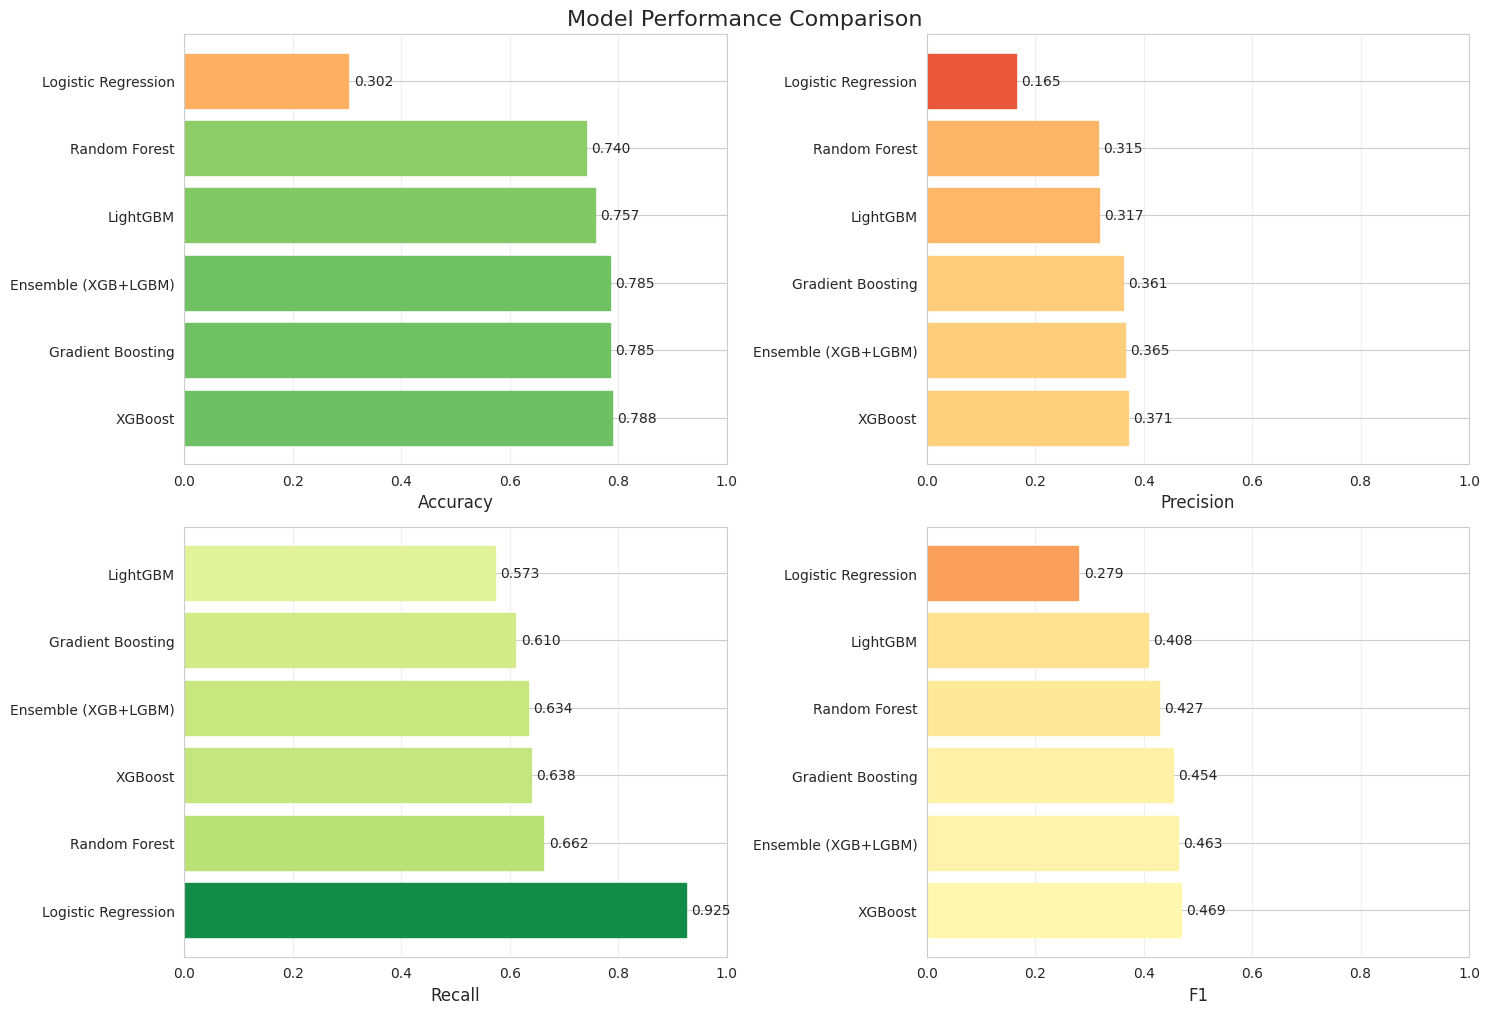

In [18]:
# ===== VISUALIZE METRICS =====
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    data = results_df.sort_values(metric, ascending=False)
    bars = ax.barh(data['Model'], data[metric])

    colors = plt.cm.RdYlGn(data[metric])
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    ax.set_xlabel(metric, fontsize=12)
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', fontsize=16, y=1.01)
plt.show()


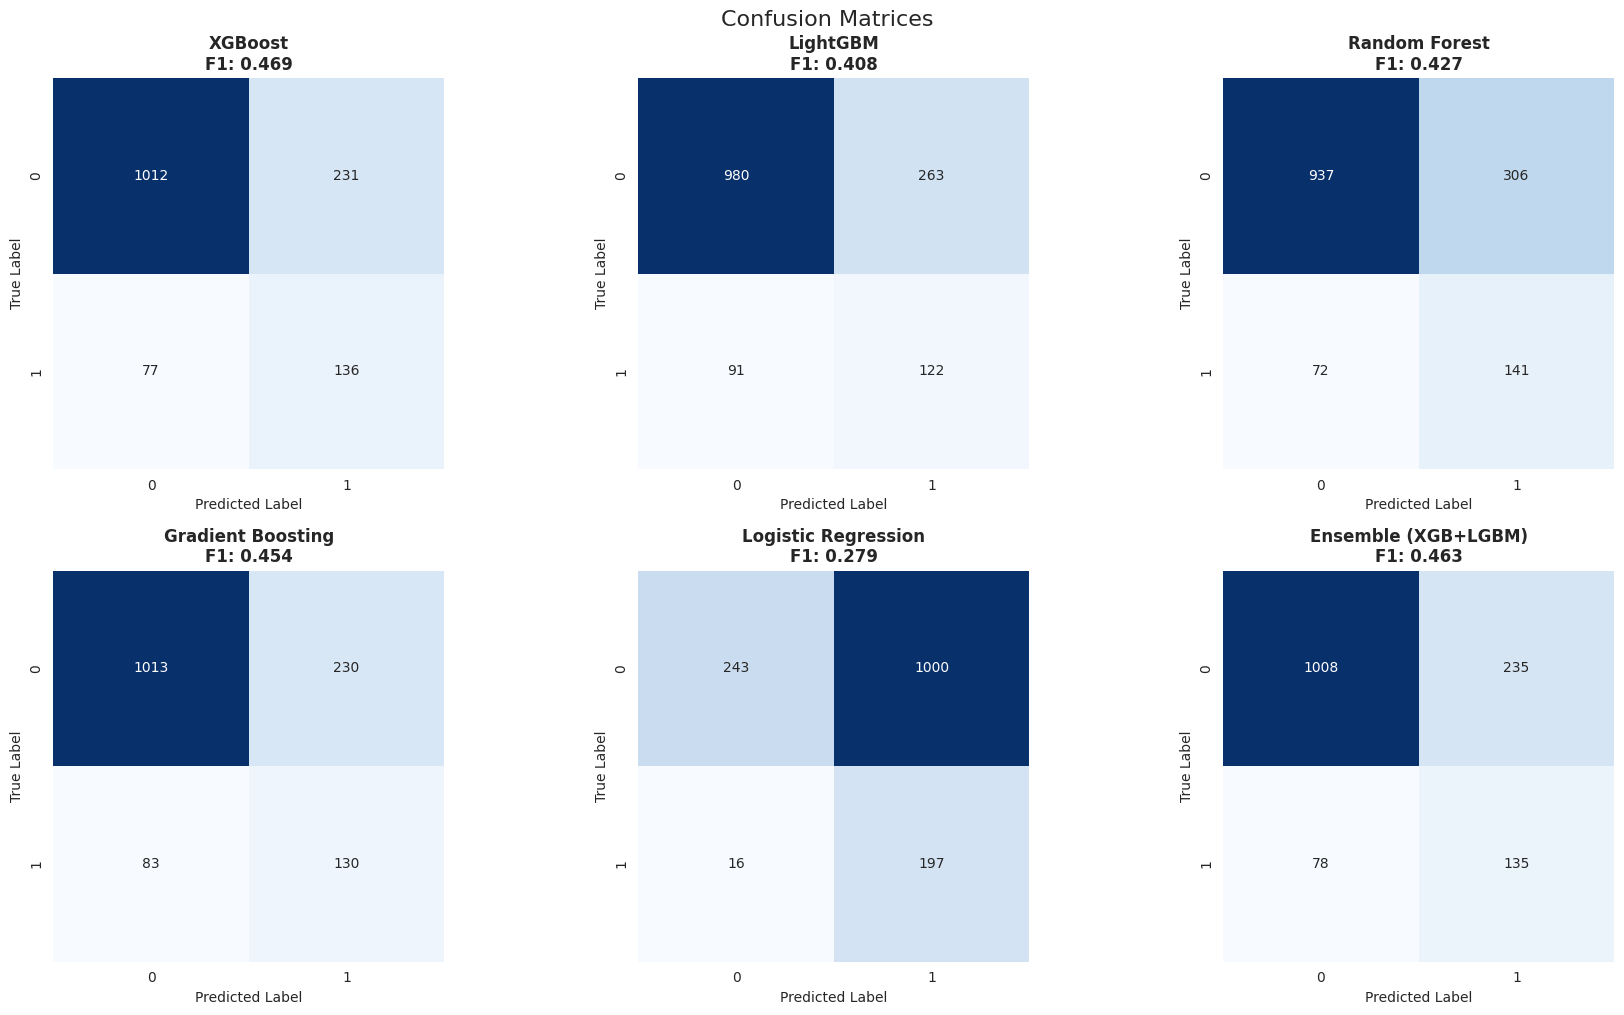

In [19]:
# ===== CONFUSION MATRICES =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, square=True)
    f1 = results_df[results_df["Model"]==name]["F1"].values[0]
    ax.set_title(f'{name}\nF1: {f1:.3f}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

if len(predictions) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Confusion Matrices', fontsize=16, y=1.01)
plt.show()

## Step 6: Advanced Visualizations & Final Recommendations

In this section, we:
- **Plot ROC curves** to compare model discrimination ability
- **Plot Precision-Recall curves** (better for imbalanced data)
- **Analyze feature importance** to understand what drives predictions
- **Provide final model recommendations** based on different use cases

### ROC Curve (Receiver Operating Characteristic)
- Shows trade-off between **True Positive Rate** and **False Positive Rate**
- **AUC = 1.0** means perfect classifier
- **AUC = 0.5** means random guessing
- Good for comparing overall model quality

### Precision-Recall Curve
- Better than ROC for **imbalanced datasets** (which we have!)
- Shows trade-off between **precision** and **recall**
- Higher curve = better performance
- Baseline = proportion of positive class

### Feature Importance
- For tree-based models, shows which features matter most
- High importance = used frequently and early in decision trees
- Helps us understand **what signals predict emerging trends**

### Model Selection Guide

Choose your model based on your business priority:
- **High Recall** - Don't miss any emerging trends (catch everything, some false alarms OK)
- **High Precision** - Only flag confident predictions (fewer alerts, but more accurate)
- **Balanced (F1)** - Good all-around performance

---

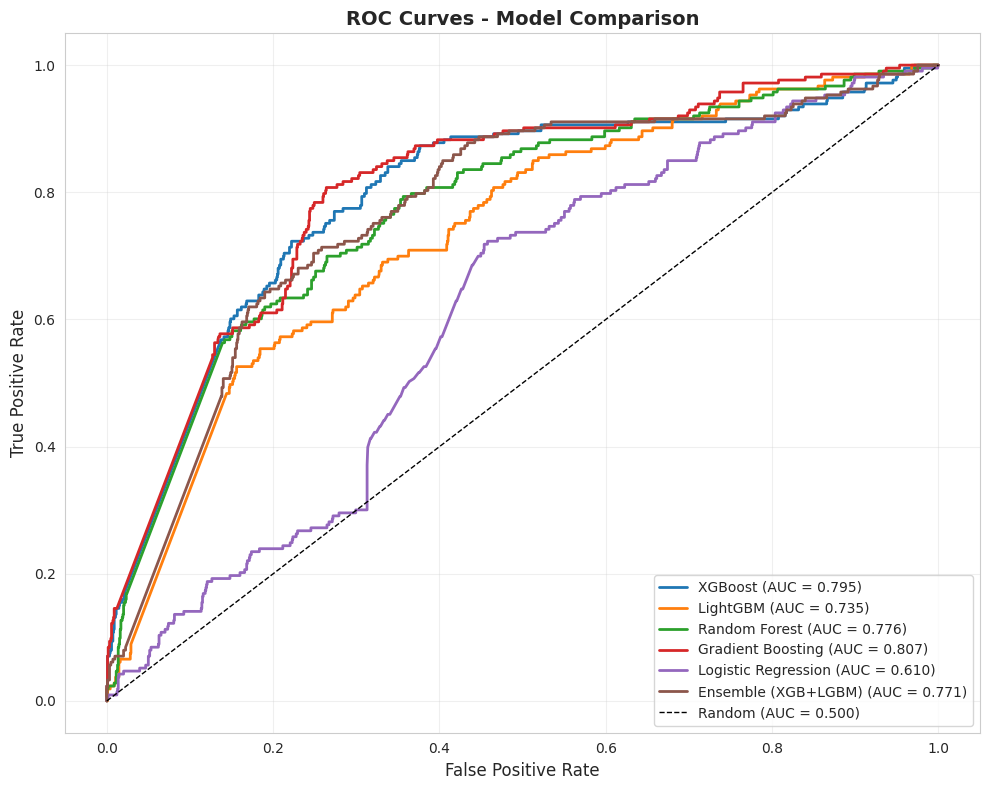

In [20]:
# ===== ROC CURVES =====
plt.figure(figsize=(10, 8))

for name, y_prob in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


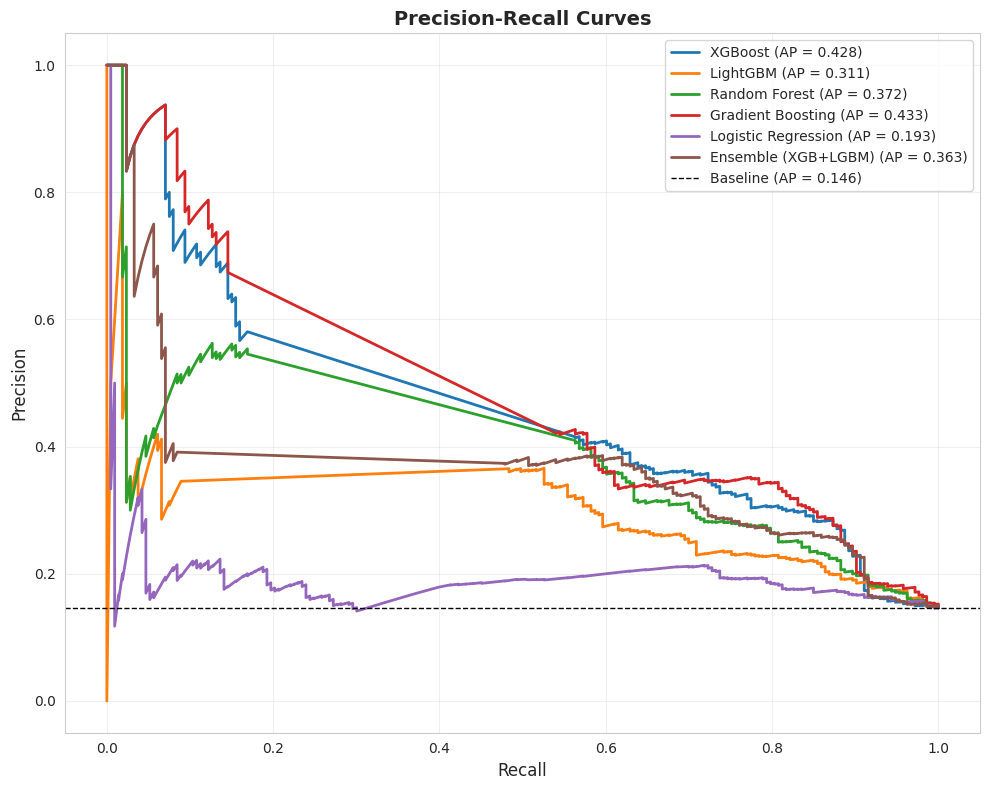

In [21]:
# ===== PRECISION-RECALL CURVES =====
plt.figure(figsize=(10, 8))

for name, y_prob in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AP = {ap:.3f})', linewidth=2)

baseline = y_test.mean()
plt.axhline(y=baseline, color='k', linestyle='--',
            label=f'Baseline (AP = {baseline:.3f})', linewidth=1)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


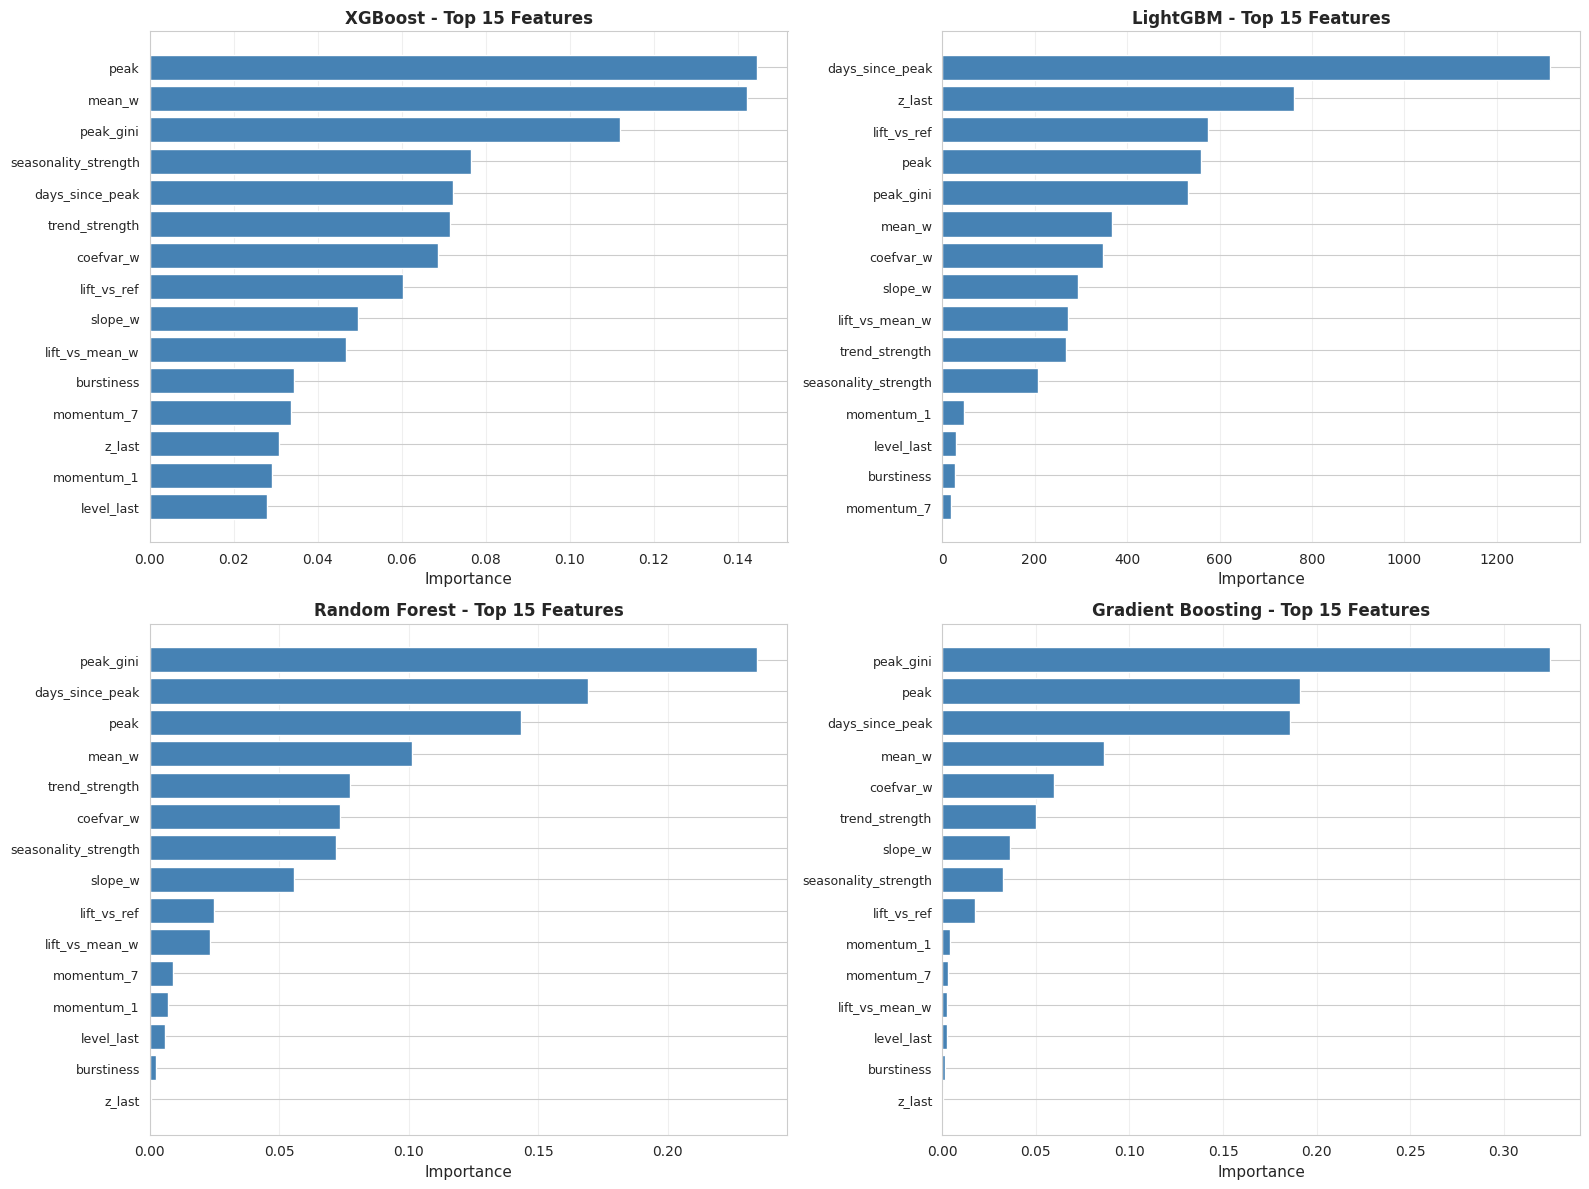

In [22]:
# ===== FEATURE IMPORTANCE =====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

tree_models = ['XGBoost', 'LightGBM', 'Random Forest', 'Gradient Boosting']
for idx, name in enumerate(tree_models):
    if name in trained_models:
        model = trained_models[name]
        importance = model.feature_importances_
        indices = np.argsort(importance)[-15:]

        ax = axes[idx]
        ax.barh(range(len(indices)), importance[indices], color='steelblue')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_cols[i] for i in indices], fontsize=9)
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(f'{name} - Top 15 Features', fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# ===== RECOMMENDATIONS =====
print("\n" + "="*80)
print("MODEL RECOMMENDATIONS")
print("="*80)

best_f1_model = results_df.loc[results_df['F1'].idxmax()]
print(f"\n🏆 BEST OVERALL MODEL: {best_f1_model['Model']}")
print(f"   F1 Score: {best_f1_model['F1']:.4f}")
print(f"   ROC-AUC: {best_f1_model['ROC-AUC']:.4f}")
print(f"   Precision: {best_f1_model['Precision']:.4f}")
print(f"   Recall: {best_f1_model['Recall']:.4f}")
print("="*80)


MODEL RECOMMENDATIONS

🏆 BEST OVERALL MODEL: XGBoost
   F1 Score: 0.4690
   ROC-AUC: 0.7952
   Precision: 0.3706
   Recall: 0.6385


In [24]:
# Keep a handle to the best model object for later use
best_model_name = best_f1_model["Model"]
best_model = trained_models[best_model_name]

print(f"\nUsing best model for live predictions: {best_model_name}")
print(f"Threshold used during evaluation: {THRESHOLD}")



Using best model for live predictions: XGBoost
Threshold used during evaluation: 0.35


# Step 7: Test best model on live Google Trends data

In [25]:
## Step 7: Test best model on the TEST dataset

# 1. Generate predictions and probabilities for the test set (X_test)
y_pred_best = best_model.predict_proba(X_test)[:, 1]
y_class_best = (y_pred_best >= THRESHOLD).astype(int)

# 2. Add prediction results to the test dataframe for easy analysis
X_test_df = df[test_mask].copy()
X_test_df['predicted_prob'] = y_pred_best
X_test_df['predicted_class'] = y_class_best

# 3. Filter for predicted "emerging" trends (class 1)
emerging_predictions = X_test_df[X_test_df['predicted_class'] == 1]
print(f"Total rows in test set: {len(X_test_df)}")
print(f"Predicted EMERGING trends (class 1): {len(emerging_predictions)}")

# 4. Show the top 10 most confidently predicted emerging trends
print("\n--- Top 10 Predicted Emerging Trends ---")
print(emerging_predictions.sort_values('predicted_prob', ascending=False)[
    ['date', 'keyword', 'target', 'predicted_prob']
].head(10).to_string(index=False))

# 5. Show final metrics for the best model on the test set
# (This re-runs the metrics specific to the best model for final context)
from sklearn.metrics import classification_report
print("\n--- Classification Report (XGBoost) ---")
print(classification_report(y_test, y_class_best, digits=4, zero_division=0))

print(f"Final Test Metrics for {best_model_name} (Threshold={THRESHOLD}):")
tn, fp, fn, tp = confusion_matrix(y_test, y_class_best).ravel()
print(f"  True Positives (TP): {tp}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Negatives (TN): {tn}")
print("================================================================================\n")

Total rows in test set: 1456
Predicted EMERGING trends (class 1): 367

--- Top 10 Predicted Emerging Trends ---
      date       keyword  target  predicted_prob
2025-03-16 mystery movie       1        0.976770
2025-03-09 mystery movie       1        0.975067
2025-03-02 mystery movie       1        0.974604
2025-03-23 mystery movie       1        0.973107
2025-03-30 mystery movie       1        0.970663
2025-06-22  family movie       0        0.941429
2025-04-06 film festival       1        0.938026
2025-03-23 film festival       1        0.924493
2025-05-18 film festival       1        0.923034
2025-04-13 film festival       1        0.917826

--- Classification Report (XGBoost) ---
              precision    recall  f1-score   support

           0     0.9293    0.8142    0.8679      1243
           1     0.3706    0.6385    0.4690       213

    accuracy                         0.7885      1456
   macro avg     0.6499    0.7263    0.6684      1456
weighted avg     0.8476    0.7885   

In [26]:
# Step 7: Test best model on live Google Trends data

# Install and import pytrends for live Google Trends data
!pip -q install pytrends
from pytrends.request import TrendReq

def fetch_weekly_trends(keyword: str,
                        timeframe: str = "today 5-y",
                        geo: str = "") -> pd.Series:
    """
    Fetch weekly Google Trends interest_over_time() for a single keyword.
    Returns a Series indexed by date with 0–100 interest scores.
    """
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], timeframe=timeframe, geo=geo)
    df_trend = pytrends.interest_over_time()

    if df_trend is None or df_trend.empty:
        raise ValueError(f"No trend data for keyword: {keyword}")

    # Column name is the keyword itself
    series = df_trend[keyword].astype(float)

    # Ensure DateTimeIndex and resample to weekly averages
    series.index = pd.to_datetime(series.index)
    weekly = series.resample("W").mean()

    return weekly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.5 MB/s eta 0:00:00


In [27]:
def predict_trend_for_keyword(keyword: str,
                              timeframe: str = "today 5-y",
                              geo: str = ""):
    """
    End-to-end:
    1. Fetch live Google Trends data.
    2. Engineer features to match training features.
    3. Apply same preprocessing (impute + scale).
    4. Use best_model to predict whether it is 'emerging'.
    """
    print(f"\n=== Live prediction for keyword: '{keyword}' ===")

    # 1) Fetch time series from Google Trends
    series = fetch_weekly_trends(keyword, timeframe=timeframe, geo=geo)
    print(f"Fetched {len(series)} weekly points from {series.index.min().date()} to {series.index.max().date()}")

    # 2) Build a 1-row feature DataFrame with same columns as training
    feat_row_raw = build_feature_row_for_keyword(
        series=series,
        feature_cols=feature_cols,
        train_df=train_df      # defined earlier: df[train_mask]
    )

    # 3) Apply SAME preprocessing (imputer + scaler)
    X_live = prepare_features(feat_row_raw)

    # 4) Predict probability and class using the best model
    prob_emerging = float(best_model.predict_proba(X_live)[0, 1])
    pred_class = int(prob_emerging >= THRESHOLD)

    label = "EMERGING" if pred_class == 1 else "STABLE"
    print(f"Predicted probability of 'emerging': {prob_emerging:.3f}")
    print(f"Using threshold {THRESHOLD:.2f} → classified as: {label}")

    return {
        "keyword": keyword,
        "prob_emerging": prob_emerging,
        "label": label
    }


In [28]:
test_keywords = [
    "Horror Movies",
    "Holiday Movies",
    "Love Triangle Movies",
    "Mystery Movies",
    "Indie Movies",
    "Action Movies",
    "Superhero Movies",
    "Foreign Language Films",
    "Award Winning Movies",
    "Documentaries",

]

live_results = []
for kw in test_keywords:
    try:
        res = predict_trend_for_keyword(kw, timeframe="today 5-y", geo="")
        live_results.append(res)
    except Exception as e:
        print(f"Error for '{kw}':", e)

pd.DataFrame(live_results)
pd.DataFrame(live_results).style.background_gradient(
    subset=["prob_emerging"], cmap="viridis"
)



=== Live prediction for keyword: 'Horror Movies' ===
Fetched 262 weekly points from 2020-11-29 to 2025-11-30
Predicted probability of 'emerging': 0.143
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'Holiday Movies' ===
Fetched 262 weekly points from 2020-11-29 to 2025-11-30
Predicted probability of 'emerging': 0.202
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'Love Triangle Movies' ===
Fetched 262 weekly points from 2020-11-29 to 2025-11-30
Predicted probability of 'emerging': 0.145
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'Mystery Movies' ===
Fetched 262 weekly points from 2020-11-29 to 2025-11-30
Predicted probability of 'emerging': 0.145
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'Indie Movies' ===
Fetched 262 weekly points from 2020-11-29 to 2025-11-30
Predicted probability of 'emerging': 0.041
Using threshold 0.35 → classified as: STABLE

=

,keyword,prob_emerging,label
0,Horror Movies,0.142911,STABLE
1,Holiday Movies,0.201973,STABLE
2,Love Triangle Movies,0.144966,STABLE
3,Mystery Movies,0.144966,STABLE
4,Indie Movies,0.041222,STABLE
5,Action Movies,0.238849,STABLE
6,Superhero Movies,0.135258,STABLE
7,Foreign Language Films,0.110734,STABLE
8,Award Winning Movies,0.123634,STABLE
9,Documentaries,0.069759,STABLE
